## Import Required Libraries

In [26]:
#from langchain_ibm import ChatWatsonx
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import List, Sequence, Annotated, TypedDict, Literal

from dotenv import load_dotenv
import os, re

## LLM

In [2]:
load_dotenv()

llm = ChatOllama(model="llama3.2:1b", temperature=0.0)

# perplexity_llm = ChatOpenAI(
#     base_url="https://api.perplexity.ai",
#     api_key=os.getenv("PERPLEXITY_API_KEY"),
#     model="sonar-pro",           # ← THIS IS THE CORRECT MODEL
#     temperature=0.0
# )

## What is Reflection?

Reflection is a prompting strategy aimed at enhancing the quality and accuracy of outputs generated by AI agents. It involves getting the agent to **pause, review, and critique** its own outputs before finalizing them. This iterative process helps in reducing errors and improving performance over time.

For example, when an AI model generates code, it typically outputs the result instantly. However, just like human programmers, code needs to be tested and refined. Reflection ensures that the AI agent **evaluates the generated code, identifies potential errors, and iterates** to fix them. This mimics how developers write, test, debug, and optimize their work, resulting in more reliable outputs.

A simple analogy is comparing it to having two systems:
- **System 1** – Reactive and instinctive (quick initial responses).
- **System 2** – Reflective and deliberate (carefully reviewing and refining outputs).

Reflection agents encourage AI to function more like **System 2**, iterating over their work until the desired quality is achieved.


### Agent State

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

### **Generation Prompt for Posts**

In [4]:
# Your prompt template (unchanged)
generation_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
        " Generate the best LinkedIn post possible for the user's request."
        " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",
    ),
    MessagesPlaceholder(variable_name="messages"),
])

### **Reflection Prompt for LinkedIn Post Critique**

In [5]:
# FIXED reflection_prompt: Remove MessagesPlaceholder - not needed for critique
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:

        1. Assess the post's overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post's potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post's relevance to the author's industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.

        Provide a detailed critique that includes:
        - A brief explanation of the post's strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.

        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical."""
    ),
    ("human", "{post_to_critique}")  # This ensures LAST message is always 'human' (user role)
])

### Chain

In [6]:
generate_chain = generation_prompt | llm
reflect_chain = reflection_prompt | llm

## StateGraph

In [7]:
graph = StateGraph(AgentState)

### Generation Node

In [8]:
def generation_node(state: AgentState) -> AgentState:
    # FIX: Pass ONLY last HumanMessage as context (or truncate history)
    # Avoid passing previous AI messages that break alternation
    last_user_msg = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), 
                        state["messages"][0])
    
    gen_result = generate_chain.invoke({
        "messages": [last_user_msg]  # Only user prompt → valid [Human]
    })
    return {"messages": [AIMessage(content=gen_result.content)]}

#### **Adding the Generate Node to the Graph**

In [9]:
graph.add_node("generate", generation_node)

### Reflection Node

In [10]:
def reflection_node(state: AgentState) -> AgentState:
    # Get LAST generated post (most recent AI message)
    last_post = next((m.content for m in reversed(state["messages"]) 
                     if isinstance(m, AIMessage)), "")
    
    critique = reflect_chain.invoke({"post_to_critique": last_post})
    return {"messages": [AIMessage(content=f"CRITIQUE: {critique.content}")]}

#### **Adding the Reflection Node to the Graph**

In [11]:
graph.add_node("reflect", reflection_node)

### Edge

In [12]:
graph.add_edge("reflect", "generate")

### **Setting the Entry Point in the Graph**

In [13]:
graph.set_entry_point("generate")

### **Adding a Router Node for Decision Making**

The router node in the graph is responsible for determining whether the workflow should proceed to the reflection phase or terminate. This decision can be made in two ways:  

1. **Predefined Logic**:  
   A simple condition is used to check the number of messages in the state. If the number of messages exceeds 6 (`len(state) > 6`), the workflow ends. Otherwise, it continues to the reflection phase.  

2. **LLM-Based Logic**:  
   Instead of relying on predefined logic, we can integrate an LLM to evaluate the context of the messages and decide whether further reflection is necessary.  

For now, we will implement the predefined logic of checking the message count. Later, we will enhance this functionality by incorporating an LLM to decide dynamically whether to proceed to the reflection phase or end the workflow.

In [14]:
# def should_continue(state: List[BaseMessage]):
#     print(state)
#     print(len(state))
#     print("----------------------------------------------------------------------")
#     if len(state) > 6:
#         return END
#     return "reflect"

In [15]:
def should_continue(state: AgentState) -> Literal["reflect", END]:
    messages = state["messages"]
    print(f"Messages count: {len(messages)}")  # Debug
    print(f"Last 3: {[m.type for m in messages[-3:]]}")
    
    # Stop after 3 full cycles (generate+reflect) = 6 AI messages
    if len([m for m in messages if isinstance(m, AIMessage)]) >= 6:
        return END
    return "reflect"

In [16]:
graph.add_conditional_edges("generate", should_continue)

### **Compiling the Workflow**

In [17]:
workflow = graph.compile()

### **Defining Inputs for the Workflow**

We define the initial user input as a `HumanMessage`. This message contains a request to improve a post related to LangChain's Tool Calling feature. The content provides the context for the workflow, which will process it and generate a refined output.

In [18]:
#inputs = HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")
inputs = {"messages": [HumanMessage(content="Write a linkedin post on getting a software developer job at IBM under 160 characters")]}

In [19]:
response = workflow.invoke(inputs)

Messages count: 2
Last 3: ['human', 'ai']
Messages count: 4
Last 3: ['ai', 'ai', 'ai']
Messages count: 6
Last 3: ['ai', 'ai', 'ai']
Messages count: 8
Last 3: ['ai', 'ai', 'ai']


In [20]:
print(type(response))
response.keys()

<class 'dict'>


dict_keys(['messages'])

In [21]:
print(type(response["messages"]))
len(response["messages"])

<class 'list'>


8

In [22]:
response["messages"][0].content

for i in range(len(response["messages"])):
    print('-'*75)
    print(response["messages"][i].content)
    print('\n')

---------------------------------------------------------------------------
Write a linkedin post on getting a software developer job at IBM under 160 characters


---------------------------------------------------------------------------
"Exciting news! I'm thrilled to share that my skills in [specific programming languages] align perfectly with IBM's cutting-edge tech stack. Let's connect and discuss how I can contribute to your innovative projects! #IBM #SoftwareDeveloper #JobSearch"


---------------------------------------------------------------------------
CRITIQUE: **Overall Quality: 7/10**
The post is straightforward and to the point, conveying a clear message about the author's skills and interest in IBM's technology stack. However, it lacks a personal touch, making it feel more like a generic job posting than an authentic self-promotion.

**Professionalism: 8/10**
The use of hashtags (#IBM) and a relevant keyword (#SoftwareDeveloper) is a good start, but the post could bene

### **Plotting the Graph**

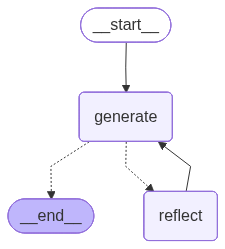

In [23]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

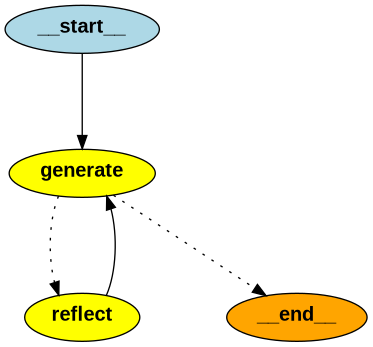

In [24]:
display(Image(workflow.get_graph().draw_png()))

### Print WorkFlow Iterations

In [27]:
def print_workflow_iterations(response):
    """Prints all generations + critiques beautifully from workflow response"""
    messages = response["messages"]
    print("🎯 WORKFLOW ITERATIONS ANALYSIS\n" + "="*60)
    
    generations = []
    critiques = []
    
    # Separate generations (odd AI indices) vs critiques (even AI indices)
    for i, msg in enumerate(messages):
        if isinstance(msg, AIMessage):
            content = msg.content.strip()
            char_count = len(content)
            hashtags = re.findall(r'#\w+', content)
            
            if i % 2 == 1:  # Odd: Generations
                generations.append({
                    'iteration': len(generations) + 1,
                    'content': content,
                    'chars': char_count,
                    'hashtags': hashtags
                })
                print(f"\n🆕 GENERATION #{len(generations)} ({char_count} chars)")
                print(f"```")
                print(content)
                print(f"```\nHashtags: {', '.join(hashtags)}")
                
            else:  # Even: Critiques (after first)
                critiques.append(content)
                print(f"📝 CRITIQUE #{len(critiques)}")
                print(f"💡 Key feedback: {content[:200]}...")
                print("-" * 50)
    
    # Summary table
    print("\n📊 SUMMARY TABLE")
    print("| Iteration | Chars | Hashtags | Length OK |")
    print("|-----------|-------|----------|-----------|")
    for gen in generations:
        print(f"| {gen['iteration']:9} | {gen['chars']:5} | {len(gen['hashtags']):7} | {'✅' if gen['chars'] <= 160 else '❌'} |")
    
    print(f"\n🏆 BEST POST (Iteration {len(generations)}):")
    print(f"```{generations[-1]['content']}```")
    print(f"Length: {generations[-1]['chars']} chars ✓")
    
    return generations, critiques

# USAGE - Replace with your actual response
generations, critiques = print_workflow_iterations(response)

# Quick access
print(f"\n🚀 First post: {generations[0]['content'][:100]}...")
print(f"📈 Final post: {generations[-1]['content']}")

🎯 WORKFLOW ITERATIONS ANALYSIS

🆕 GENERATION #1 (252 chars)
```
"Exciting news! I'm thrilled to share that my skills in [specific programming languages] align perfectly with IBM's cutting-edge tech stack. Let's connect and discuss how I can contribute to your innovative projects! #IBM #SoftwareDeveloper #JobSearch"
```
Hashtags: #IBM, #SoftwareDeveloper, #JobSearch
📝 CRITIQUE #1
💡 Key feedback: CRITIQUE: **Overall Quality: 7/10**
The post is straightforward and to the point, conveying a clear message about the author's skills and interest in IBM's technology stack. However, it lacks a person...
--------------------------------------------------

🆕 GENERATION #2 (252 chars)
```
"Exciting news! I'm thrilled to share that my skills in [specific programming languages] align perfectly with IBM's cutting-edge tech stack. Let's connect and discuss how I can contribute to your innovative projects! #IBM #SoftwareDeveloper #JobSearch"
```
Hashtags: #IBM, #SoftwareDeveloper, #JobSearch
📝 CRITIQUE

In [28]:
# First generated post (cycle 1)
print(response["messages"][1].content)  # Initial generation
print('-'*75)
# First critique  
print(response["messages"][2].content)  # Reflect1
print('-'*75)
# Second generation (refined)
print(response["messages"][3].content)  # Generate2
print('-'*75)
# All AI generations (odd indices after Human)
generations = [m.content for i, m in enumerate(response["messages"]) 
               if isinstance(m, AIMessage) and i % 2 == 1]
print("All generations:", generations)

"Exciting news! I'm thrilled to share that my skills in [specific programming languages] align perfectly with IBM's cutting-edge tech stack. Let's connect and discuss how I can contribute to your innovative projects! #IBM #SoftwareDeveloper #JobSearch"
---------------------------------------------------------------------------
CRITIQUE: **Overall Quality: 7/10**
The post is straightforward and to the point, conveying a clear message about the author's skills and interest in IBM's technology stack. However, it lacks a personal touch, making it feel more like a generic job posting than an authentic self-promotion.

**Professionalism: 8/10**
The use of hashtags (#IBM) and a relevant keyword (#SoftwareDeveloper) is a good start, but the post could benefit from more attention to formatting and tone. The language is professional, but it's not particularly engaging or creative.

**Structure/Tone: 6/10**
The post is structured in a straightforward manner, with each sentence building on the pre